In the previous notebook, we explored various tensorflow models and found that the U-net model was the most capable neural network for simulating erosion. Although the model is able to generate results that somewhat resembles the training target data, it did not manage to replicate the fine details of the errosion simulations. The changes of the landscape due to erosion are very subtle and so it is difficult to learn.

We could further improve the model and get it to learn the more subtle details, but for now it is easier to simply generate data with more dramatic landscape changes.

# Running this Notebook

To run this notebook, I reccomend using [this docker environment for GOSPL](https://hub.docker.com/r/geodels/gospl). The main libraries needed here are GOSPL and Pyvista. In the next notebook, we will not be using GOSPL, but tensorflow instead.

In [1]:
import h5py
import stripy
import meshplex
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from gospl.model import Model as sim
from gospl._fortran import definegtin
from TrainingDataGenerator import DataGenerator

# Data Generator

To simplify the code, I created the *TrainingDataGenerator.py* script that handles GOSPL simulations using an object oriented approach. This helps us avoid having to pass and keep track of the many parameters involved. Most of the code and algorithms used by the data generator are already described in the first notebook of the first attempt of this project. You can read the first notebook to understand the theory in more detail. In addition to the previous code, the data generator also handles tectonic uplift forces for the GOSPL simulation.

Bellow we demonstrate how we can specify various simulation parameters. Note that these are all optional input parameters, and we can initiate the data generator without specifying any of these, in this case the data generator will simply use their default settings.

We also provide a visualization of the initial topography (elevations) and the tectonic uplift.

In [2]:
# Noise parameters for initial topography and tectonic uplift
topographyNoiseParameters = {
    "octaves" : 8,
    "octaveStepSize" : 1.4,
    "amplitudeStepSize" : 2.0,
    "initialFrequency" : 0.000001,
    "noiseMinMax" : np.array([-4000, 1000])}
upliftNoiseParameters = {
    "octaves" : 6,
    "octaveStepSize" : 1.4,
    "amplitudeStepSize" : 2.4,
    "initialFrequency" : 0.0000002,
    "noiseMinMax" : np.array([0, 2000])}

# We initialise the data generator with desired parameters
datGen = DataGenerator(
    
                # Mesh and simulation parameters
                subdivisions = 6, #Subdivisions for the icosphere
                radius = 6378137, #Earths radius in meters
                
                # Time related parameters
                startTime = 0, #Simulation start time in years
                endTime = 60000000, #Simulation end time in years
                tOut = 1000000, #Write data files at every tOut number of years
                deltaTime = 100000, #Time steps for the simulation
                tecTime = 1000000,
                
                # Noise parameters for initial topography and tectonic uplift
                topographyNoiseParameters = topographyNoiseParameters,
                upliftNoiseParameters = upliftNoiseParameters,
                
                # Main directory to store results in
                dataDir = './SecondDataSets/GosplTrials'
)

# Visualize initial elevations and tectonic uplift
plotter = pv.PlotterITK()
plotter.add_mesh(datGen.icoMesh, scalars='elevations')
#plotter.add_mesh(datGen.icoMesh, scalars='uplift')
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

We can then run a gospl simulation trial as follows. Within the main results data directory, the data generator will create a subdirectory name *Trial{}* followed by some number. The number is chosen based on how many trials data is already present in the main results directory.

In [3]:
# Change to true to actually run the trial
if False:
    datGen.prepareAndRunGOSPLtrial()

# Generating Lots of Data

We can also automatically run many GOSPL simulation trials using the code bellow. For the purpose of training a neural network, we will need data generated from hundreds of trials, so we can simply let the code bellow run over long periods of time until the user interupts by restarting the jupyter notebook kernel.

After interupting the code bellow, the latest running trial will probably be incomplete, so make sure to delete the latest trial subdirectory.

In the future, we could randomise some of the GOSPL simulation parameters, and implement the paramters as inputs of the neural network. Hoever, to do so we will require significantly more training examples, and it will complicate things further.

In [4]:
endTime = 60000000
deltaTime = 100000
dataDir = './Data/TrialsWithSubdivision6'

# Run many GOSPL trials until user interupts
while False:
    datGen = DataGenerator(
        dataDir = dataDir,
        endTime = endTime,
        deltaTime = deltaTime)
    datGen.prepareAndRunGOSPLtrial()

# Visualizing Results Data

After running some GOSPL simulations, we can visualize the results as follows. This will create an mesh of the results with exagerated elevations. 

Note that to properly load simulation trial, we need to make sure that we initiate the *DataGenerator* with the some of the same parameters that were used to run the simulation itself. The *subdivisions* parameter and any directory related parameters will all need to be the same.

In the top left corner of the ITK plotter window, there is a dropdown meny represented by 3 lines. Within this dropdown menu, we can chose which results parameter to color code the mesh with.

In [5]:
trialNumber = 33
iterationToPlot = 60
amplificationFactor = 90
dataDir = './Data/TrialsWithSubdivision6'

# Load trial and animate results
datGen = DataGenerator(dataDir=dataDir,
                      amplificationFactor=amplificationFactor)
datGen.loadTrial(trialNumber)

# Create mesh from results data with exagerated elevations
gosplDict = datGen.readGosplFile(iterationToPlot)
mesh = datGen.createExageratedMesh(gosplDict)

# Plot the results
plotter = pv.PlotterITK()
plotter.add_mesh(mesh, scalars='elev')
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Alternatively, we can also create an animations of the results as follows. By default, this animation will be saved as an MP4 file in the same directory of this notebook.

In [6]:
trialNumber = 33
endTime = 60000000
numberOfIterations = 60
amplificationFactor = 120
animationDir = 'ErosionAnimation.mp4'
dataDir = './Data/TrialsWithSubdivision6'

# Load trial and animate results
datGen = DataGenerator(dataDir=dataDir,
                      animationDir=animationDir,
                      endTime=endTime,
                      amplificationFactor=amplificationFactor)
datGen.loadTrial(trialNumber)
datGen.animateGosplResults(iterations=numberOfIterations, scalarToPlot='elev')

# Processing Data for Tensorflow

For now, we plan on training a convolutional neural network, which requires our data to be in an array shaped similar to those of images, however GOSPL requires the data to be on an Icosphere. By interpolating our data onto a UV sphere, we can treat the longitudinal and latitudinal coordinates like the X and Y axis of image data, and thus bring the data into the required format.

In the future, we could potentially avoid this by using mesh based neural networks, however this will complicate things for now and the tools/literature are no where near as well established.

In [7]:
trialNumber = 0
finalIteration = 60
uvSphereResolution = [512, 258]
dataDir = './Data/TrialsWithSubdivision6'
scalarsToInterpolate = ['elev', 'erodep', 'flowAcc']

# Initiate data generator and load trial
datGen = DataGenerator(dataDir = dataDir, 
                       uvSphereResolution = uvSphereResolution,
                       scalarsToInterpolate = scalarsToInterpolate)
datGen.loadTrial(trialNumber)

# Interpolate data onto UV sphere
inputData = datGen.interpolateInputDataToUVsphere(finalIteration=finalIteration)
outputData = datGen.interpolateGosplDataToUVsphere(finalIteration=finalIteration)

# Add interpolated data to uvSphere mesh (for visualization)
uvSphere = datGen.uvSphere
uvSphere['initialElevations'] = inputData[0]
uvSphere['tectonicUplift'] = inputData[1]
uvSphere['finalElevations'] = outputData[0]
uvSphere['erosionDeposition'] = outputData[1]
uvSphere['flowAccumulation'] = outputData[2]**0.125

# Plot the results
plotter = pv.PlotterITK()
plotter.add_mesh(uvSphere, scalars='finalElevations')
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In the code bellow, we demonstrate how the data would look like in an image format. In doing so, we need to remove data on vertices corresponding to the north and south poles of the planet, because we otherwise can not reshape the arrays into the desired formats. This is a more accurate representation of how tensorflow will actually receive its training data, and what it is trying to learn.

In the image corresponding to the output data:
- Red represents the final elevations
- Green represents the erosion deposition
- Blue represents the flow accumulation

Note that we normalize and adjust the data to make features more visible, but these modifications are not required for them to be compatible with tensorflow. We might however, pass the data through a sigmoid function to bring them into a range of $[0, 1]$, without strictly imposing a height limit on elevations and other parameters. We could also include additional output parameters for the neural network to learn, which could potentially improve the model, as it has more data to work with.

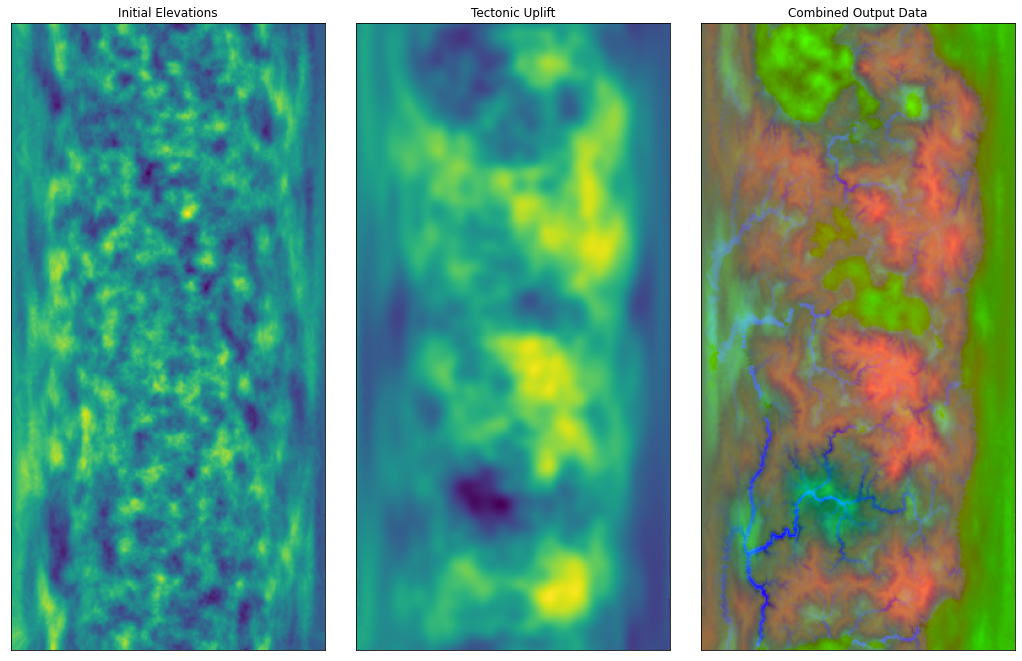

In [8]:
trialNumber = 1
finalIteration = 60
uvSphereResolution = [512, 258]
dataDir = './Data/TrialsWithSubdivision6'
scalarsToInterpolate = ['elev', 'erodep', 'flowAcc']

# Initiate data generator and load trial
datGen = DataGenerator(dataDir = dataDir, 
                       uvSphereResolution = uvSphereResolution,
                       scalarsToInterpolate = scalarsToInterpolate)
datGen.loadTrial(trialNumber)

# Interpolate input data onto UV sphere and normalize just for the purpose of visualization
inputDat = datGen.interpolateInputDataToUVsphere(finalIteration=finalIteration)
inputDat = inputDat.T[2:]
inputDat -= np.min(inputDat, axis=0)
inputDat /= np.max(inputDat, axis=0)
inputDat = inputDat.reshape(uvSphereResolution[0], uvSphereResolution[1]-2, 2)

# Interpolate output data onto UV sphere and normalize just for the purpose of visualization
outputData = datGen.interpolateGosplDataToUVsphere(finalIteration=finalIteration)
outputData[2] **= 0.125
outputData = outputData.T[2:]
outputData -= np.min(outputData, axis=0)
outputData /= np.max(outputData, axis=0)
outputData = outputData.reshape(uvSphereResolution[0], uvSphereResolution[1]-2, 3)

#Set up plotting figure
fig, axis = plt.subplots(1, 3)
fig.set_figheight(12)
fig.set_figwidth(18)
axis[0].imshow(inputDat[:, :, 0])
axis[1].imshow(inputDat[:, :, 1])
axis[2].imshow(outputData)
axis[0].set_title('Initial Elevations')
axis[1].set_title('Tectonic Uplift')
axis[2].set_title('Combined Output Data')
axis[0].set_xticks([])
axis[0].set_yticks([])
axis[1].set_xticks([])
axis[1].set_yticks([])
axis[2].set_xticks([])
axis[2].set_yticks([])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

Now that we have shown how the final data set will be represented, all that is left to do is to iterate over all GOSPL trial directories, pre-process the data and save them all into a single NPZ file.

In [4]:
maxTrialNumber = 1771
finalIteration = 60
uvSphereResolution = [512, 258]
dataDir = './Data/TrialsWithSubdivision6Batch3'
scalarsToInterpolate = ['elev', 'erodep', 'flowAcc']
outputTrainingDatasetDir = './Data/TrainingDataSets/Bacth3.npz'

featureDataset = []
targetDataset = []

# Iterate over all trials and process data for tensorflow
for trialNumber in range(maxTrialNumber+1):
    if (trialNumber%10==0):
        print(trialNumber)
    datGen = DataGenerator(dataDir = dataDir, 
                           uvSphereResolution = uvSphereResolution,
                           scalarsToInterpolate = scalarsToInterpolate)
    datGen.loadTrial(trialNumber)

    # Interpolate input data onto UV sphere and normalize just for the purpose of visualization
    inputDat = datGen.interpolateInputDataToUVsphere(finalIteration=finalIteration)
    inputDat = inputDat.T[2:]
    inputDat = inputDat.reshape(uvSphereResolution[0], uvSphereResolution[1]-2, 2)
    featureDataset.append(inputDat)

    # Interpolate output data onto UV sphere and normalize just for the purpose of visualization
    outputData = datGen.interpolateGosplDataToUVsphere(finalIteration=finalIteration)
    outputData = outputData.T[2:]
    outputData = outputData.reshape(uvSphereResolution[0], uvSphereResolution[1]-2, 3)
    targetDataset.append(outputData)

# Save all processed data as an NPZ file
featureDataset = np.array(featureDataset)
targetDataset = np.array(targetDataset)
np.savez(outputTrainingDatasetDir, features=featureDataset, targets=targetDataset)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
